Enron Fraud Dataset 安隆公司詐欺案  
https://www.kaggle.com/competitions/2021-ml100marathon-midterm/overview

問題:  
1. 安隆公司曾是一間能源公司，擁有上千億資產的公司於 2002 年竟然在短短幾周內宣告破產，找出可疑嫌疑人
2. 提供欄位 (總共21個欄位，email相關6個，除了email_address，其餘皆為次數；財務相關15個)  
3. 預期產出poi的機率 (poi: 這個欄位標記員工是否是可疑人員)
4. 為監督式學習中的分類問題

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from mlxtend.classifier import StackingClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

data_path = './'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')

train_Y = df_train['poi']
df_train = df_train.drop(['poi'] , axis=1)
df = pd.concat([df_train, df_test])
df.head()

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


<span style="font-size: larger;">Part1. EDA探索性分析</span>

In [3]:
df.shape

(146, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 0 to 32
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       146 non-null    object 
 1   bonus                      82 non-null     float64
 2   deferral_payments          39 non-null     float64
 3   deferred_income            49 non-null     float64
 4   director_fees              17 non-null     float64
 5   email_address              111 non-null    object 
 6   exercised_stock_options    102 non-null    float64
 7   expenses                   95 non-null     float64
 8   from_messages              86 non-null     float64
 9   from_poi_to_this_person    86 non-null     float64
 10  from_this_person_to_poi    86 non-null     float64
 11  loan_advances              4 non-null      float64
 12  long_term_incentive        66 non-null     float64
 13  other                      93 non-null     float64


In [5]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df = dtype_df.groupby("Column Type").aggregate('count').reset_index()
dtype_df

,Column Type,Count
0,float64,19
1,object,2


In [6]:
float_features = []
object_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64':
        float_features.append(feature)
    else:
        object_features.append(feature)
        
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

19 Float Features : ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']

2 Object Features : ['name', 'email_address']


In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df[float_features].describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,82.00,39.00,49.00,17.00,102.00,95.00,86.00,86.00,86.00,4.00,66.00,93.00,110.00,18.00,95.00,86.00,86.00,125.00,126.00
mean,2374234.61,1642674.15,-1140475.14,166804.88,5987053.77,108728.92,608.79,64.90,41.23,41962500.00,1470361.45,919064.97,2321741.14,166410.56,562194.29,1176.47,2073.86,5081526.49,6773957.45
std,10713327.97,5161929.97,4025406.38,319891.41,31062006.57,533534.81,1841.03,86.98,100.07,47083208.70,5942759.32,4589252.91,12518278.18,4201494.31,2716369.15,1178.32,2582.70,29061716.40,38957772.73
min,70000.00,-102500.00,-27992891.00,3285.00,3285.00,148.00,12.00,0.00,0.00,400000.00,69223.00,2.00,-2604490.00,-7576788.00,477.00,2.00,57.00,148.00,-44093.00
25%,431250.00,81573.00,-694862.00,98784.00,527886.25,22614.00,22.75,10.00,1.00,1600000.00,281250.00,1215.00,254018.00,-389621.75,211816.00,249.75,541.25,394475.00,494510.25
50%,769375.00,227449.00,-159792.00,108579.00,1310813.50,46950.00,41.00,35.00,8.00,41762500.00,442035.00,52382.00,451740.00,-146975.00,259996.00,740.50,1211.00,1101393.00,1102872.50
75%,1200000.00,1002671.50,-38346.00,113784.00,2547724.00,79952.50,145.50,72.25,24.75,82125000.00,938672.00,362096.00,1002369.75,-75009.75,312117.00,1888.25,2634.75,2093263.00,2949846.75
max,97343619.00,32083396.00,-833.00,1398517.00,311764000.00,5235198.00,14368.00,528.00,609.00,83925000.00,48521928.00,42667589.00,130322299.00,15456290.00,26704229.00,5521.00,15149.00,309886585.00,434509511.00


<span style="font-size: larger;">A.缺失值比例</span>  
● loan_advances、director_fees、restricted_stock_deferred缺失值比例太大，可以考慮移除

In [8]:
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
loan_advances,97.26
director_fees,88.36
restricted_stock_deferred,87.67
deferral_payments,73.29
deferred_income,66.44
long_term_incentive,54.79
bonus,43.84
from_messages,41.10
from_poi_to_this_person,41.10
from_this_person_to_poi,41.10


<span style="font-size: larger;">B.資料分布圖</span>  
● 因資料分布多呈現右偏，所以需要將資料先去偏態，再建模

In [9]:
#email
df['email_address']= np.where(df['email_address'].notnull(),1,0) #有mail=1，無mail=0
email_features =['from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi','shared_receipt_with_poi', 'to_messages', 'email_address']

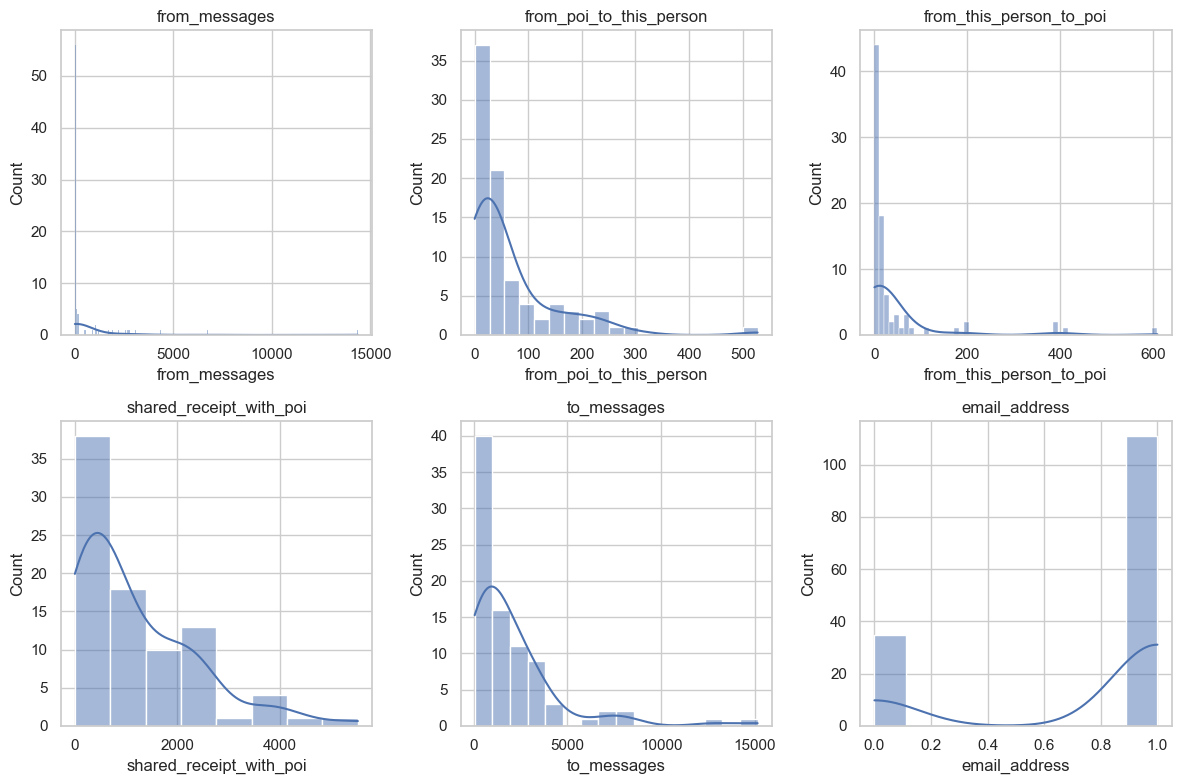

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

for i, column in enumerate(email_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

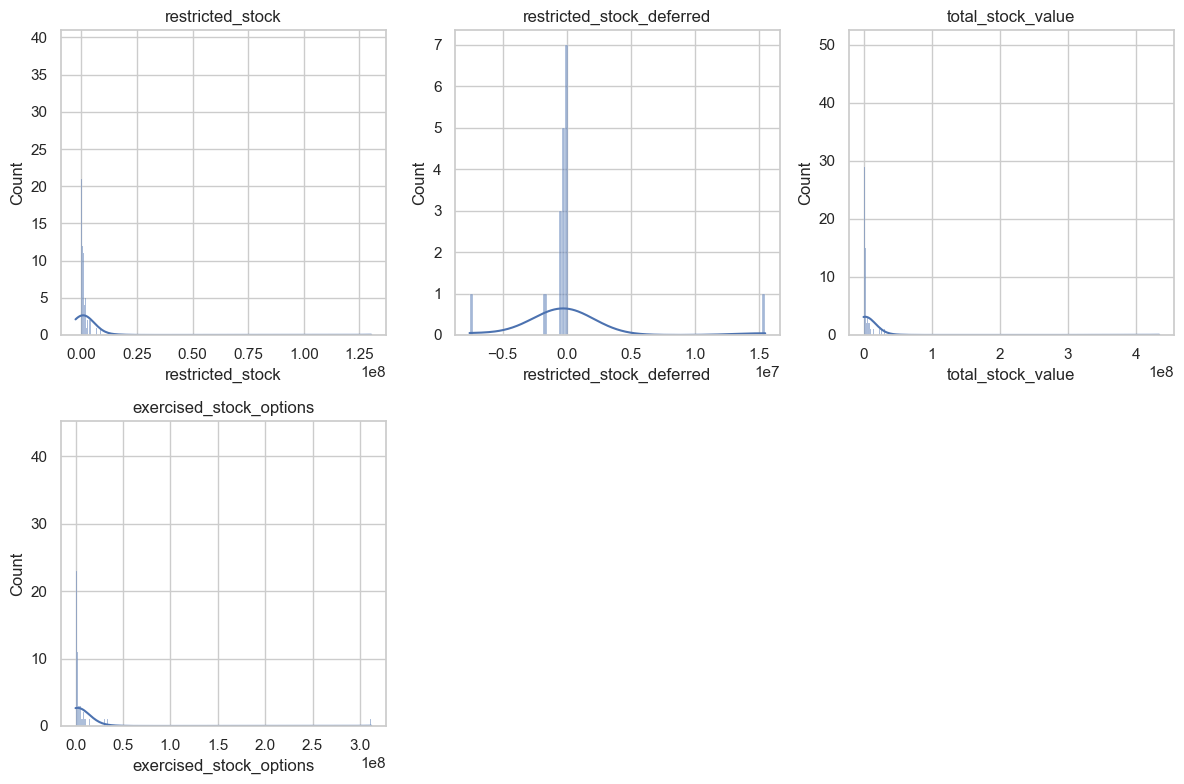

In [11]:
#stock
stock_features=['restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'exercised_stock_options']
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))

for i, column in enumerate(stock_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

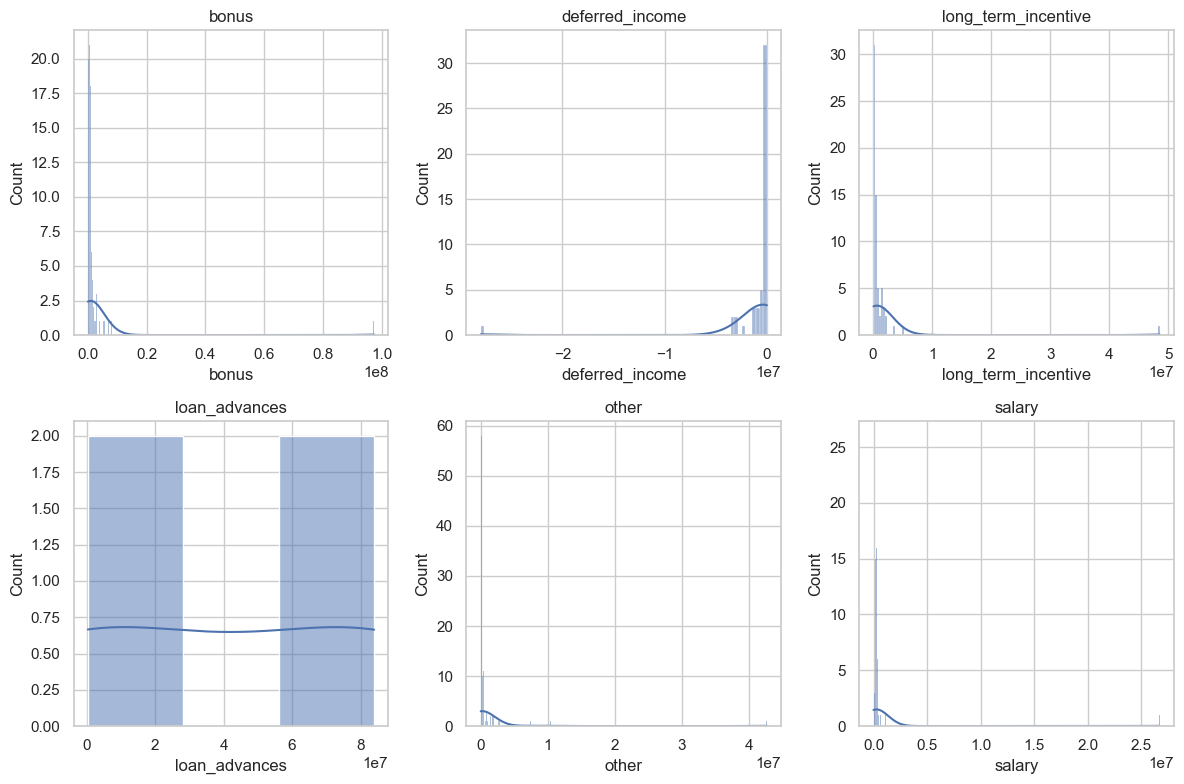

In [13]:
#income and bonus  
income_features=['bonus' ,'deferred_income', 'long_term_incentive', 'loan_advances', 'other', 'salary']
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

for i, column in enumerate(income_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

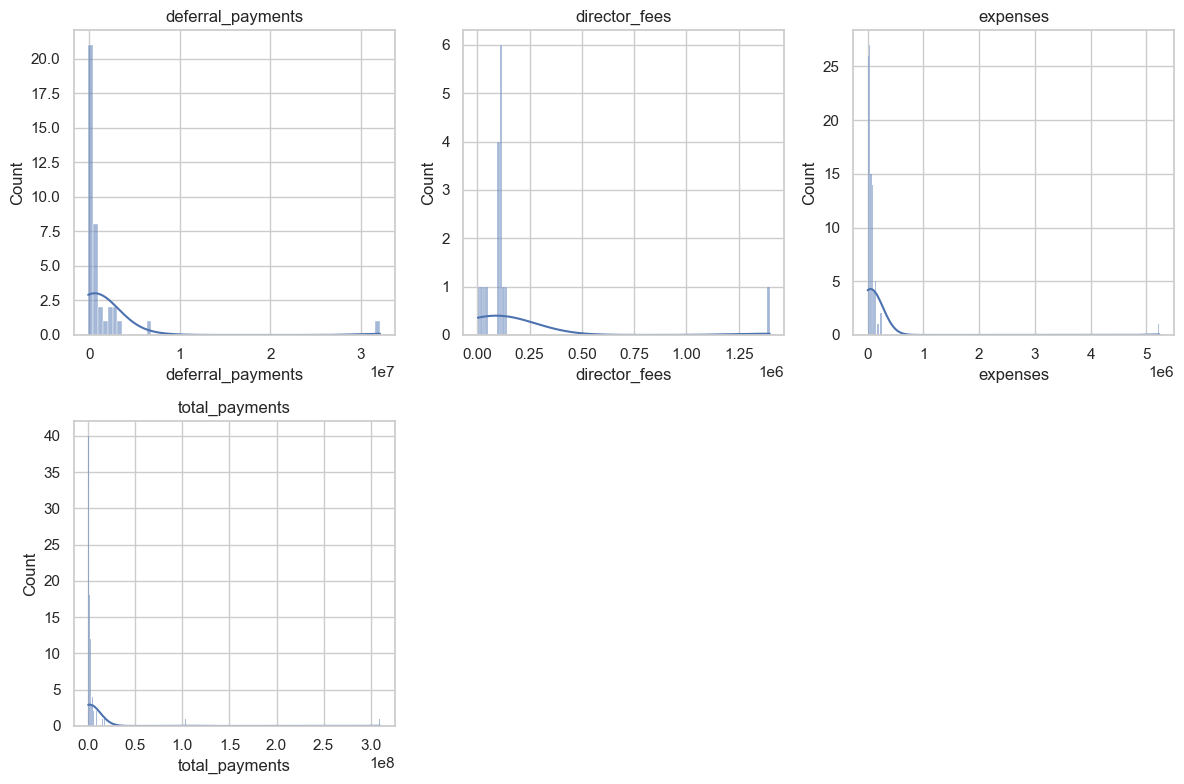

In [14]:
#payments  
payments_features=['deferral_payments', 'director_fees', 'expenses', 'total_payments']
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

for i, column in enumerate(payments_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

<span style="font-size: larger;">B.相關性</span>

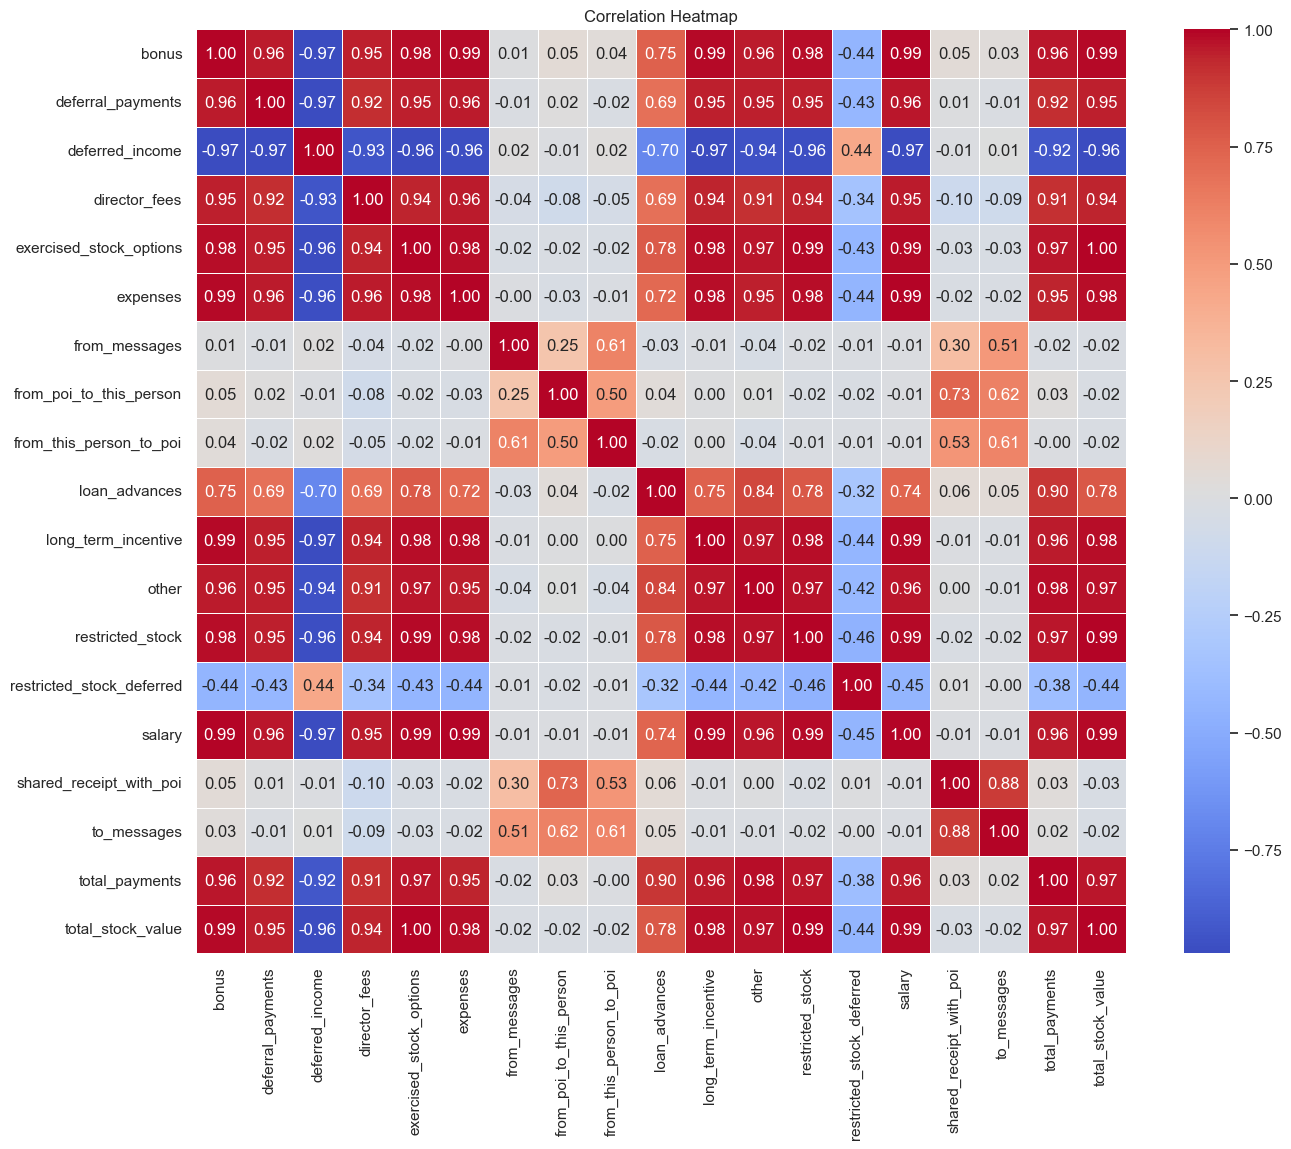

In [41]:
correlation_matrix = df[float_features].fillna(0).corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

<span style="font-size: larger;">Part2. 資料前處理</span>

In [32]:
df_c= df.copy()
df_c[float_features] = df_c[float_features].fillna(0) #缺值補0
df_c= df_c.drop(['loan_advances','director_fees','restricted_stock_deferred'], axis=1) #缺值比例太高

#右偏資料去偏態，除了email已轉成01，其他欄位都取對數做轉換
df_mail=df_c['email_address']
df_name=df_c['name']

df_c = df_c.drop(['name','email_address'], axis=1) #先移除name, email_address
for i in df_c.columns:
    df_c[i]=df_c[i].apply(lambda x: np.log1p(x) if x > 0 else 0)

df_c= pd.concat([df_c, df_mail], axis=1) 
df_c.head()

,bonus,deferral_payments,deferred_income,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,email_address
0,14.38,0.00,0,16.80,10.76,2.94,3.76,1.61,14.30,12.07,14.83,12.95,6.76,6.81,13.13,16.93,1
1,15.54,0.00,0,16.77,10.29,4.69,4.49,3.43,14.47,10.00,15.74,13.92,7.62,8.20,15.98,17.08,1
2,12.21,0.00,0,14.30,10.04,3.69,2.64,2.71,0.00,14.27,13.68,12.26,4.52,5.42,14.51,14.73,1
3,13.59,0.00,0,0.00,11.68,0.00,0.00,0.00,13.31,13.72,13.80,12.32,0.00,0.00,14.79,13.80,1
4,14.04,0.00,0,0.00,10.49,4.98,5.30,3.26,12.84,6.19,11.74,12.39,7.69,7.86,14.31,11.74,1


In [35]:
print(df_c.isnull().any().any()) #檢查缺失值
print(df_c.shape)

False
(146, 17)


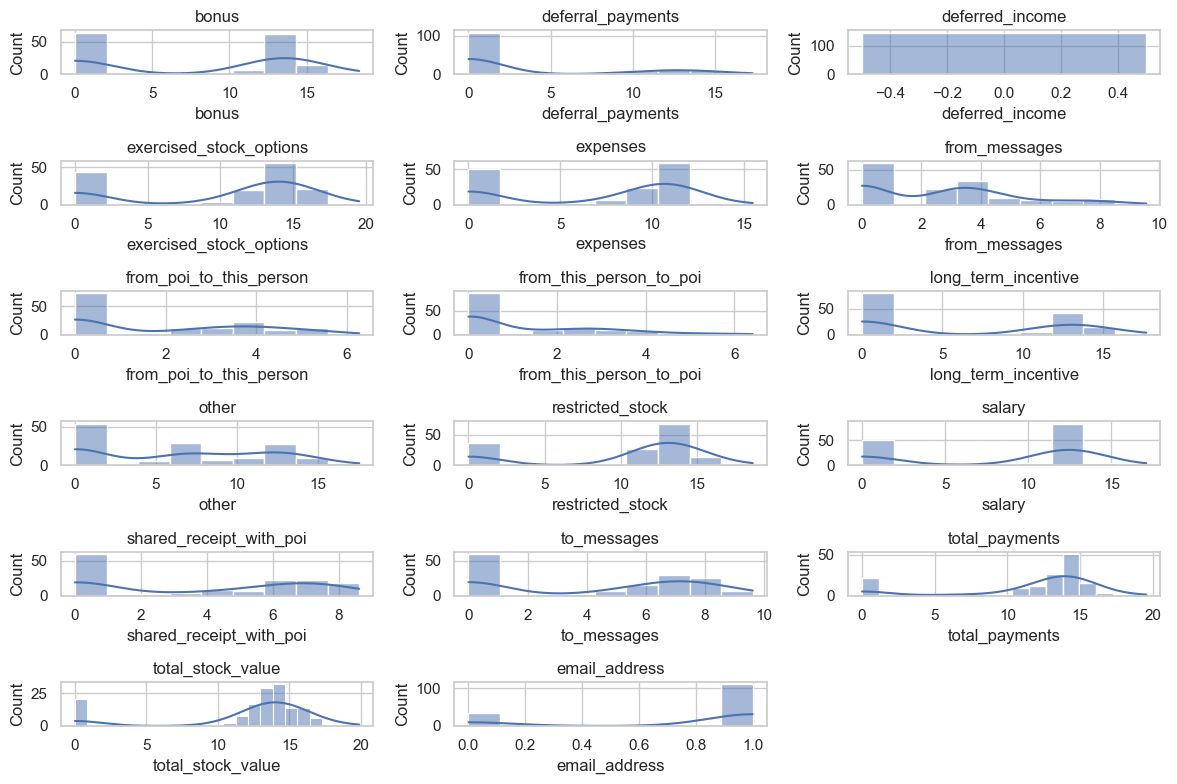

In [38]:
#看一下轉換後的資料分布
num_features = len(df_c.columns)
rows = num_features//3 + (num_features % 3 >0) # 每行最多 3 張圖
cols = min(3, num_features) # 最多 3 列

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

for i, column in enumerate(df_c.columns):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_c[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

<span style="font-size: larger;">Part3. 建模</span>

In [57]:
#標準化資料 
df_c = StandardScaler().fit_transform(df_c)

# 資料切分
train_num = train_Y.shape[0]
train_X = df_c[: train_num]
test_X = df_c[train_num: ]

#區分訓練集與測試集
from sklearn.model_selection import train_test_split, GridSearchCV
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.3,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((79, 17), (34, 17), (79,), (34,))

1. LogisticRegression

In [108]:
#LogisticRegression
LR = LogisticRegression(random_state=42)
LR.fit(x_train, y_train)
y_pred = LR.predict(x_test)
print(f'LogisticRegression Accuracy: {accuracy_score(y_test, y_pred)}')

LogisticRegression Accuracy: 0.8235294117647058


In [115]:
LR_pred=LR.predict_proba(test_X)[:,1]
LR_sub = pd.DataFrame({"name": df_test["name"], "poi": LR_pred})
LR_sub.to_csv("LR_poi.csv", index=False)

2. Decision tree

In [103]:
#Decision tree(預設)
DT = DecisionTreeClassifier(random_state=42)
DT.fit(x_train, y_train)
y_pred = DT.predict(x_test)
print(f'DecisionTreeClassifier Accuracy: {accuracy_score(y_test, y_pred)}')

DecisionTreeClassifier Accuracy: 0.8529411764705882


In [88]:
#Decision tree(調參)
max_depth = np.arange(3,51) #樹的深度 
min_samples_split = np.arange(5,51) #至少有多少資料才能再分
min_samples_leaf = np.arange(5,51) #分完至少有多少資料才能分
param_grid = dict(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

DT_grid_search = GridSearchCV(DT, param_grid, scoring="accuracy", n_jobs=-1, verbose=1) #窮舉法
DT_grid_result = DT_grid_search.fit(x_train, y_train)
print("Best Accuracy: %f using %s" % (DT_grid_result.best_score_, DT_grid_result.best_params_))

Fitting 5 folds for each of 101568 candidates, totalling 507840 fits
Best Accuracy: 0.899167 using {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 16}


In [101]:
DT_bestparams = DT_grid_search.best_estimator_
DT_bestparams.fit(x_train, y_train)
y_pred = DT_bestparams.predict(x_test)
print("Decision Tree Accuracy: %.3f" % accuracy_score(y_test, y_pred))

Decision Tree Accuracy: 0.853


In [102]:
DT_pred = DT_bestparams.predict_proba(test_X)[:,1]
DT_sub = pd.DataFrame({"name": df_test["name"], "poi": DT_pred})
DT_sub.to_csv("DT_poi.csv", index=False)

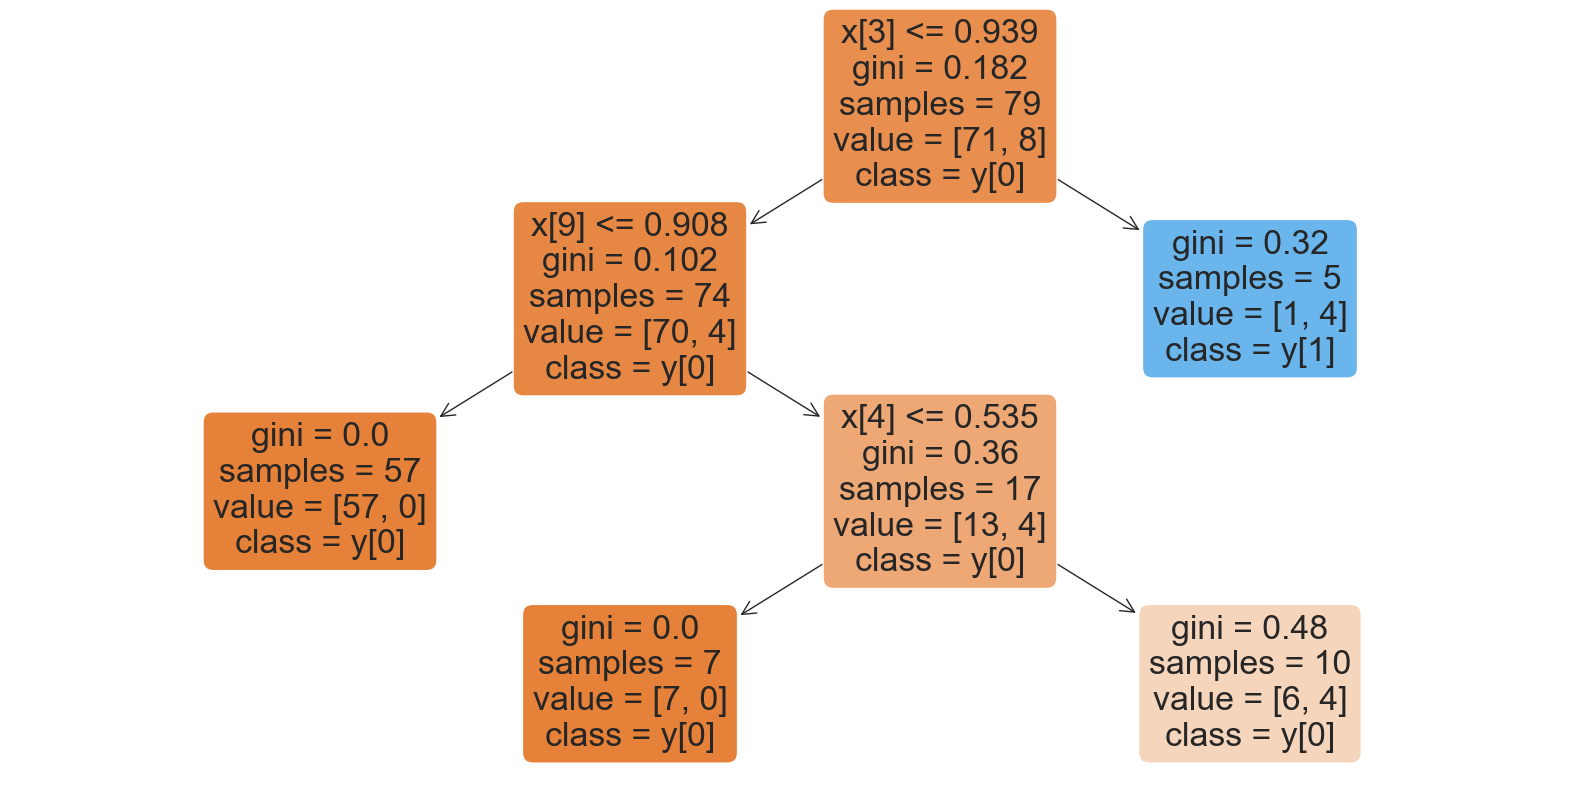

In [117]:
# 使用最佳參數擬合模型
DT_best_model = DecisionTreeClassifier(max_depth=DT_grid_result.best_params_['max_depth'],
                                     min_samples_split=DT_grid_result.best_params_['min_samples_split'],
                                     min_samples_leaf=DT_grid_result.best_params_['min_samples_leaf'])
DT_best_model.fit(x_train, y_train)

# 繪製決策樹圖
plt.figure(figsize=(20, 10))
plot_tree(DT_best_model, class_names=True, filled=True, rounded=True)
plt.show()

3. Random Forest

In [130]:
#Random Forest(預設)
RF = RandomForestClassifier(random_state=42)
RF.fit(x_train, y_train)
y_pred = RF.predict(x_test)
print(f'RandomForestClassifier: {accuracy_score(y_test, y_pred)}')

RandomForestClassifier: 0.8529411764705882


In [131]:
#Random Forest(調參)
n_estimators = np.arange(5,105, 5)
max_depth  = np.arange(3,51)
min_samples_split = np.arange(5,51)
min_samples_leaf = np.arange(5,51)
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

RF_grid_search = RandomizedSearchCV(RF, param_grid, scoring="accuracy", n_jobs=-1, verbose=1)
RF_grid_result = RF_grid_search.fit(x_train, y_train)
print("Best Accuracy: %f using %s" % (RF_grid_result.best_score_, RF_grid_result.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Accuracy: 0.899167 using {'n_estimators': 65, 'min_samples_split': 46, 'min_samples_leaf': 16, 'max_depth': 10}


In [132]:
RF_bestparams = RF_grid_search.best_estimator_
RF_bestparams.fit(x_train, y_train)
y_pred = RF_bestparams.predict(x_test)
print("Random Forest Accuracy: %.3f" % accuracy_score(y_test, y_pred))

Random Forest Accuracy: 0.853


In [134]:
RF_pred = RF_bestparams.predict_proba(test_X)[:,1]
RF_sub = pd.DataFrame({"name": df_test["name"], "poi": RF_pred})
RF_sub.to_csv("RF_poi.csv", index=False)

4. GDBT

In [137]:
#GDBT(預設)
GDBT = GradientBoostingClassifier(random_state=42, learning_rate=0.1)
GDBT.fit(x_train, y_train)
y_pred = GDBT.predict(x_test)
print("Gradient Boosting Accuracy: %.3f" % accuracy_score(y_test, y_pred))

Gradient Boosting Accuracy: 0.853


In [138]:
#GDBT(調參)
n_estimators = np.arange(5,105, 5)
max_depth  = np.arange(3,51)
min_samples_split = np.arange(5,51)
min_samples_leaf = np.arange(5,51)
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

GDBT_grid_search = RandomizedSearchCV(GDBT, param_grid, scoring="accuracy", n_jobs=-1, verbose=1)
GDBT_grid_result = GDBT_grid_search.fit(x_train, y_train)
print("Best Accuracy: %f using %s" % (GDBT_grid_result.best_score_, GDBT_grid_result.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Accuracy: 0.899167 using {'n_estimators': 40, 'min_samples_split': 45, 'min_samples_leaf': 38, 'max_depth': 8}


In [149]:
GDBT_bestparams = GDBT_grid_search.best_estimator_
GDBT_bestparams.fit(x_train, y_train)
y_pred = GDBT_bestparams.predict(x_test)
print("GDBT Accuracy: %.3f" % accuracy_score(y_test, y_pred))

GDBT Accuracy: 0.853


In [140]:
GDBT_pred = GDBT_bestparams.predict_proba(test_X)[:,1]
GDBT_sub = pd.DataFrame({"name": df_test["name"], "poi": GDBT_pred})
GDBT_sub.to_csv("GDBT_poi.csv", index=False)

1. 觀察四種模型上傳結果: 除了Decision tree的 Private Score =0.55之外，其他三種(LR,RF,GDBT)都>0.7 
2. 為了提高Private Score，再進行Blending (混和泛化) 、 Stacking(堆疊泛化) 

Blending

In [144]:
blending_pred = LR_pred*0.3 + RF_pred*0.4 + GDBT_pred*0.3
sub = pd.DataFrame({"name": df_test["name"], "poi": blending_pred})
sub.to_csv("blending_poi.csv", index=False)

In [151]:
blending_v2_pred = LR_pred*0.25 + RF_pred*0.5 + GDBT_pred*0.25
sub = pd.DataFrame({"name": df_test["name"], "poi": blending_v2_pred})
sub.to_csv("blending_v2_poi.csv", index=False)

Stacking

In [148]:
meta_estimator = GDBT_bestparams
stacking = StackingClassifier(classifiers=[LR, RF_bestparams, GDBT_bestparams], meta_classifier=meta_estimator, 
                              use_probas=True, average_probas=False)

stacking.fit(train_X, train_Y)
stacking_pred = stacking.predict_proba(test_X)[:,1]
sub = pd.DataFrame({"name": df_test["name"], "poi": stacking_pred})
sub.to_csv("stacking_poi.csv", index=False)

In [152]:
meta_estimator = RF_bestparams
stacking_v2 = StackingClassifier(classifiers=[LR, RF_bestparams, GDBT_bestparams], meta_classifier=meta_estimator, 
                              use_probas=True, average_probas=False)

stacking_v2.fit(train_X, train_Y)
stacking_v2_pred = stacking_v2.predict_proba(test_X)[:,1]
sub = pd.DataFrame({"name": df_test["name"], "poi": stacking_v2_pred})
sub.to_csv("stacking_v2_poi.csv", index=False)

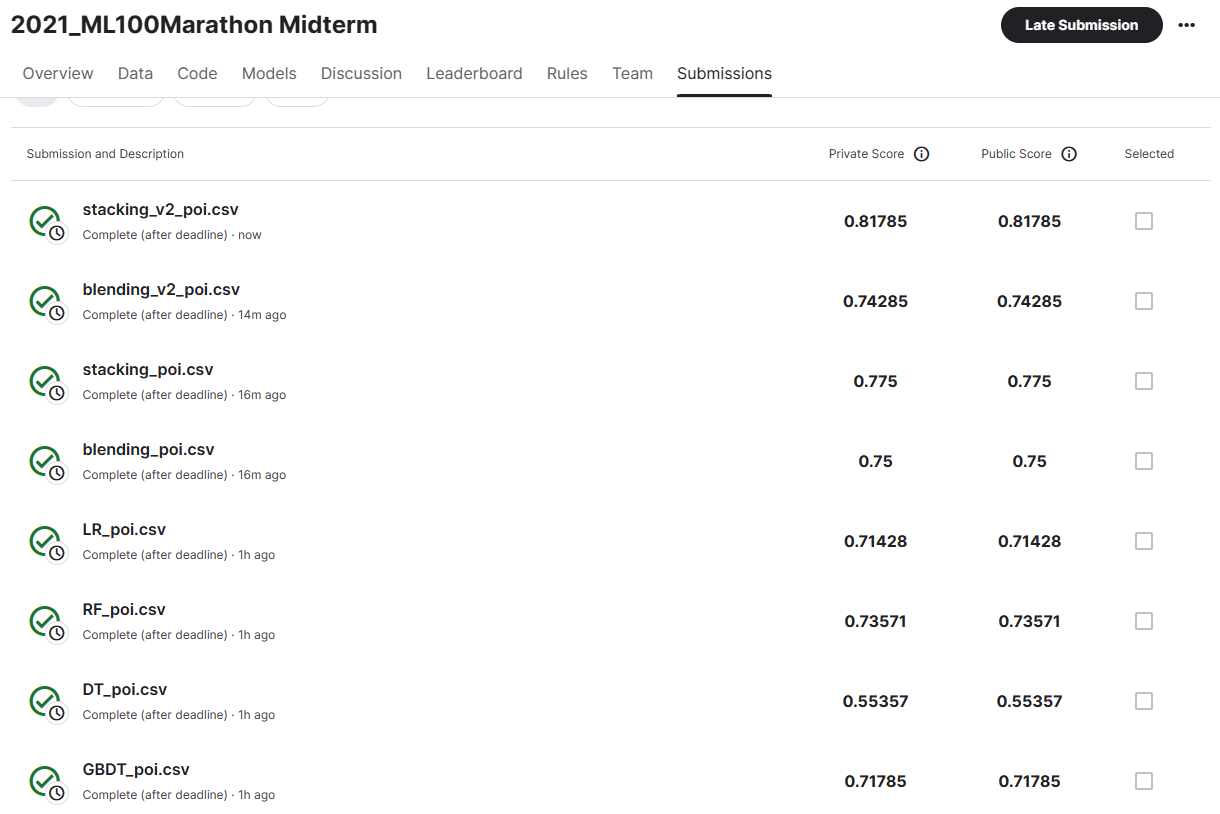

In [153]:
from IPython import display
display.Image("Kaggle.png")